# Water Segmentation — Enhanced (indices, imbalance handling, stronger aug)

**This notebook is an enhanced version of your pipeline.** It keeps the from-scratch UNet and adds:

- Class imbalance checking and automatic weighting / focal loss option
- NDWI & MNDWI added as explicit channels (computed per-sample)
- Stronger augmentations for robustness
- Post-processing helper to remove small spurious regions

Drop this notebook into your `notebooks/` folder and run top-to-bottom. Adjust `CONFIG` if needed.

## 1) Environment & imports
Uncomment pip install line in Colab if needed.

In [54]:
# !pip install -q tifffile albumentations==1.3.0 scikit-learn matplotlib seaborn torchvision torch --upgrade

import os, random, time, math, shutil
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from tqdm import tqdm

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

import albumentations as A
from albumentations.pytorch import ToTensorV2

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

import tifffile as tiff
from skimage import morphology, measure

print('Imports ready. device:', 'cuda' if torch.cuda.is_available() else 'cpu')

Imports ready. device: cuda


## 2) CONFIG — paths and training settings
Edit paths if needed. This matches your layout with `data/data/images` and `data/data/labels`. 

In [55]:
# Configure paths (run from notebooks/)
cwd = Path.cwd().resolve()
if cwd.name == 'notebooks':
    ROOT = cwd.parent
else:
    ROOT = cwd.parents[1] if len(cwd.parents) >= 2 else cwd

DATA_DIR = ROOT / "data" / "data"   # <-- your layout: project_root/data/data/images
IMG_DIR = DATA_DIR / "images"
LAB_DIR = DATA_DIR / "labels"

_cpu = os.cpu_count() or 1
safe_workers = 0 if os.name == 'nt' else min(4, max(0, _cpu-1))

CONFIG = {
    'project_root': str(ROOT),
    'img_dir': str(IMG_DIR),
    'label_dir': str(LAB_DIR),
    'in_channels': 12,   # original 12-band count
    'height': 128, 'width': 128,
    'batch_size': 16,
    'num_workers': safe_workers,
    'epochs': 60,
    'lr': 1e-3,
    'device': 'cuda' if torch.cuda.is_available() else 'cpu',
    'seed': 42,
    'save_dir': str(ROOT / 'experiments_enhanced'),
    # enhanced options:
    'use_indices': True,      # append NDWI + MNDWI to channel set (computed on the fly)
    'loss_type': 'bce_dice',  # options: 'bce_dice', 'weighted_bce_dice', 'focal_dice'
    'focal_gamma': 2.0,       # if focal selected
    'min_component_size': 100 # pixels, for post-processing cleanup
}

Path(CONFIG['save_dir']).mkdir(parents=True, exist_ok=True)

random.seed(CONFIG['seed']); np.random.seed(CONFIG['seed']); torch.manual_seed(CONFIG['seed'])
if CONFIG['device'].startswith('cuda'): torch.cuda.manual_seed_all(CONFIG['seed'])

print('CONFIG summary:')
print(' IMG_DIR:', CONFIG['img_dir'], 'exists?', Path(CONFIG['img_dir']).exists())
print(' LAB_DIR:', CONFIG['label_dir'], 'exists?', Path(CONFIG['label_dir']).exists())
print(' device:', CONFIG['device'], 'num_workers:', CONFIG['num_workers'])
CONFIG

CONFIG summary:
 IMG_DIR: C:\Users\Eng.Razan\Documents\Cellula Projects\Cellula-intern\data\data\images exists? True
 LAB_DIR: C:\Users\Eng.Razan\Documents\Cellula Projects\Cellula-intern\data\data\labels exists? True
 device: cuda num_workers: 0


{'project_root': 'C:\\Users\\Eng.Razan\\Documents\\Cellula Projects\\Cellula-intern',
 'img_dir': 'C:\\Users\\Eng.Razan\\Documents\\Cellula Projects\\Cellula-intern\\data\\data\\images',
 'label_dir': 'C:\\Users\\Eng.Razan\\Documents\\Cellula Projects\\Cellula-intern\\data\\data\\labels',
 'in_channels': 12,
 'height': 128,
 'width': 128,
 'batch_size': 16,
 'num_workers': 0,
 'epochs': 60,
 'lr': 0.001,
 'device': 'cuda',
 'seed': 42,
 'save_dir': 'C:\\Users\\Eng.Razan\\Documents\\Cellula Projects\\Cellula-intern\\experiments_enhanced',
 'use_indices': True,
 'loss_type': 'bce_dice',
 'focal_gamma': 2.0,
 'min_component_size': 100}

## 3) Utilities — readers, indices, normalizer

In [56]:
import re
def read_raster(path):
    p = Path(path)
    ext = p.suffix.lower()
    if ext in ('.tif', '.tiff'):
        arr = tiff.imread(str(p))
        if arr.ndim == 3:
            if arr.shape[2] <= 16 and arr.shape[0] > 16:
                arr = np.transpose(arr, (2,0,1))
        elif arr.ndim == 2:
            arr = arr[None,...]
        return arr.astype(np.float32)
    else:
        im = Image.open(str(p))
        if im.mode in ('1','L','P'):
            arr = np.array(im.convert('L'))[None,...]
        else:
            rgb = np.array(im.convert('RGB')).astype(np.float32)
            arr = np.transpose(rgb, (2,0,1))
        return arr.astype(np.float32)

def safe_div(a,b): return a/(b+1e-8)

CHANNEL_NAMES = ["Coastal","Blue","Green","Red","NIR","SWIR1","SWIR2","QA","MeritDEM","CopernicusDEM","ESA_WC","WaterProb"]
B_COASTAL, B_BLUE, B_GREEN, B_RED, B_NIR, B_SWIR1, B_SWIR2, B_QA, B_MERITDEM, B_COPERNICUSDEM, B_ESAWC, B_WATERPROB = range(12)

def compute_indices(arr):
    green = arr[B_GREEN]; nir = arr[B_NIR]; swir1 = arr[B_SWIR1]; red = arr[B_RED]
    ndwi = safe_div(green - nir, green + nir)
    mndwi = safe_div(green - swir1, green + swir1)
    ndvi = safe_div(nir - red, nir + red)
    return {'NDWI': ndwi, 'MNDWI': mndwi, 'NDVI': ndvi}

class BandNormalizers:
    def __init__(self, mode='clip01'):
        assert mode in ('zscore','minmax','clip01')
        self.mode = mode
        self.means = None; self.stds = None; self.mins = None; self.maxs = None
    def fit(self, file_list, sample_n=300):
        rng = np.random.default_rng(CONFIG['seed'])
        picks = rng.choice(file_list, size=min(len(file_list), sample_n), replace=False)
        sums=None; sqs=None; mins=None; maxs=None; total=0
        for p in picks:
            arr = read_raster(p)
            C = arr.shape[0]; H,W = arr.shape[1], arr.shape[2]
            if sums is None:
                sums = np.zeros(C, dtype=np.float64); sqs = np.zeros(C, dtype=np.float64)
                mins = np.full(C, np.inf, dtype=np.float64); maxs = np.full(C, -np.inf, dtype=np.float64)
            for c in range(C):
                band = arr[c].ravel()
                sums[c] += band.sum()
                sqs[c] += (band**2).sum()
                mins[c] = min(mins[c], float(band.min()))
                maxs[c] = max(maxs[c], float(band.max()))
            total += H*W
        self.means = sums/total
        self.stds  = np.sqrt(np.maximum(1e-8, sqs/total - self.means**2))
        self.mins = mins; self.maxs = maxs
        print('Normalizers computed:', self.mode)
    def transform(self, arr):
        out = arr.copy().astype(np.float32)
        C = out.shape[0]
        if self.mode == 'zscore':
            for c in range(C):
                out[c] = (out[c] - self.means[c])/(self.stds[c]+1e-8)
        elif self.mode == 'minmax':
            for c in range(C):
                mn,mx = self.mins[c], self.maxs[c]
                out[c] = (out[c] - mn)/(mx-mn+1e-8)
        else:
            for c in range(C):
                p1 = np.percentile(out[c],1); p99=np.percentile(out[c],99)
                out[c] = np.clip(out[c],p1,p99); out[c] = (out[c]-p1)/(p99-p1+1e-8)
        return out

print('Utilities ready')

Utilities ready


## 4) Data listing & matching

In [57]:
from collections import defaultdict

root_img_dir = Path(CONFIG['img_dir']); root_label_dir = Path(CONFIG['label_dir'])

img_files = sorted(list(root_img_dir.glob('*.tif')) + list(root_img_dir.glob('*.tiff')))
label_files = sorted(list(root_label_dir.glob('*.png')) + list(root_label_dir.glob('*.jpg')) + list(root_label_dir.glob('*.jpeg')) + list(root_label_dir.glob('*.tif')))

print('Found images:', len(img_files), 'Found labels:', len(label_files))
print('Example images:', [p.name for p in img_files[:10]])
print('Example labels:', [p.name for p in label_files[:10]])

label_map = {p.stem: p for p in label_files}
label_basenames = list(label_map.keys())

def match_label(img_stem):
    if img_stem in label_map: return label_map[img_stem]
    for m in label_basenames:
        if m.startswith(img_stem + '_') or m.endswith('_' + img_stem):
            return label_map[m]
    pat = re.compile(r'(^|[^0-9])' + re.escape(img_stem) + r'([^0-9]|$)')
    for m in label_basenames:
        if pat.search(m): return label_map[m]
    for m in label_basenames:
        tokens = re.findall(r'\d+', m)
        if img_stem in tokens: return label_map[m]
    for m in label_basenames:
        if img_stem in m: return label_map[m]
    return None

matches = {}
unmatched = []
used_labels = set()
for p in img_files:
    m = match_label(p.stem)
    if m:
        matches[str(p)] = str(m)
        used_labels.add(str(m))
    else:
        unmatched.append(str(p))

unused_labels = [str(p) for p in label_files if str(p) not in used_labels]
print(f"Matched: {len(matches)}  Unmatched images: {len(unmatched)}  Unused labels: {len(unused_labels)}")

Found images: 306 Found labels: 456
Example images: ['0.tif', '1.tif', '10.tif', '100.tif', '101.tif', '102.tif', '103.tif', '104.tif', '105.tif', '106.tif']
Example labels: ['0.png', '1.png', '10.png', '100.png', '100_184.png', '101.png', '101_89.png', '102.png', '102_179.png', '103.png']
Matched: 306  Unmatched images: 0  Unused labels: 150


## 5-a) EDA & class-balance check
Check water % per image and overall class balance.

Images with zero water: 45 out of 306
Mean water fraction: 0.2597528594771242 median: 0.164459228515625


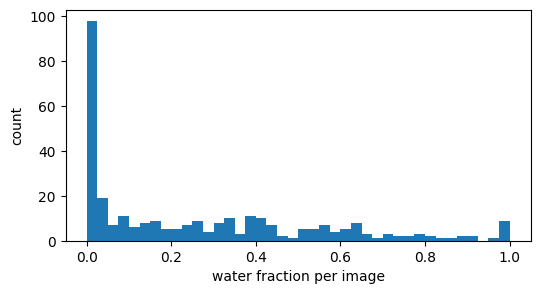

Train/Val/Test counts: 214 45 47
Train mean water fraction: 0.2235637914354556


In [58]:
frac_list = []
for img_p, lab_p in list(matches.items()):
    lab = read_raster(lab_p)[0]
    lab = (lab > 0).astype(np.uint8)
    frac_list.append(lab.mean())
frac_arr = np.array(frac_list)
print('Images with zero water:', (frac_arr==0).sum(), 'out of', len(frac_arr))
print('Mean water fraction:', frac_arr.mean(), 'median:', np.median(frac_arr))
plt.figure(figsize=(6,3)); plt.hist(frac_arr, bins=40); plt.xlabel('water fraction per image'); plt.ylabel('count'); plt.show()

# quick split stats
all_items = list(matches.items()); random.shuffle(all_items)
n = len(all_items)
n_train = int(0.7 * n); n_val = int(0.15 * n); n_test = n - n_train - n_val
train_items = all_items[:n_train]; val_items = all_items[n_train:n_train+n_val]; test_items = all_items[n_train+n_val:]
print('Train/Val/Test counts:', len(train_items), len(val_items), len(test_items))
print('Train mean water fraction:', np.mean([ (read_raster(x[1])[0]>0).mean() for x in train_items ]))

## 5-b) Per-sample visualization — per-sample bands, composites, indices

Image: 0.tif  Bands: 12  Shape: 128x128


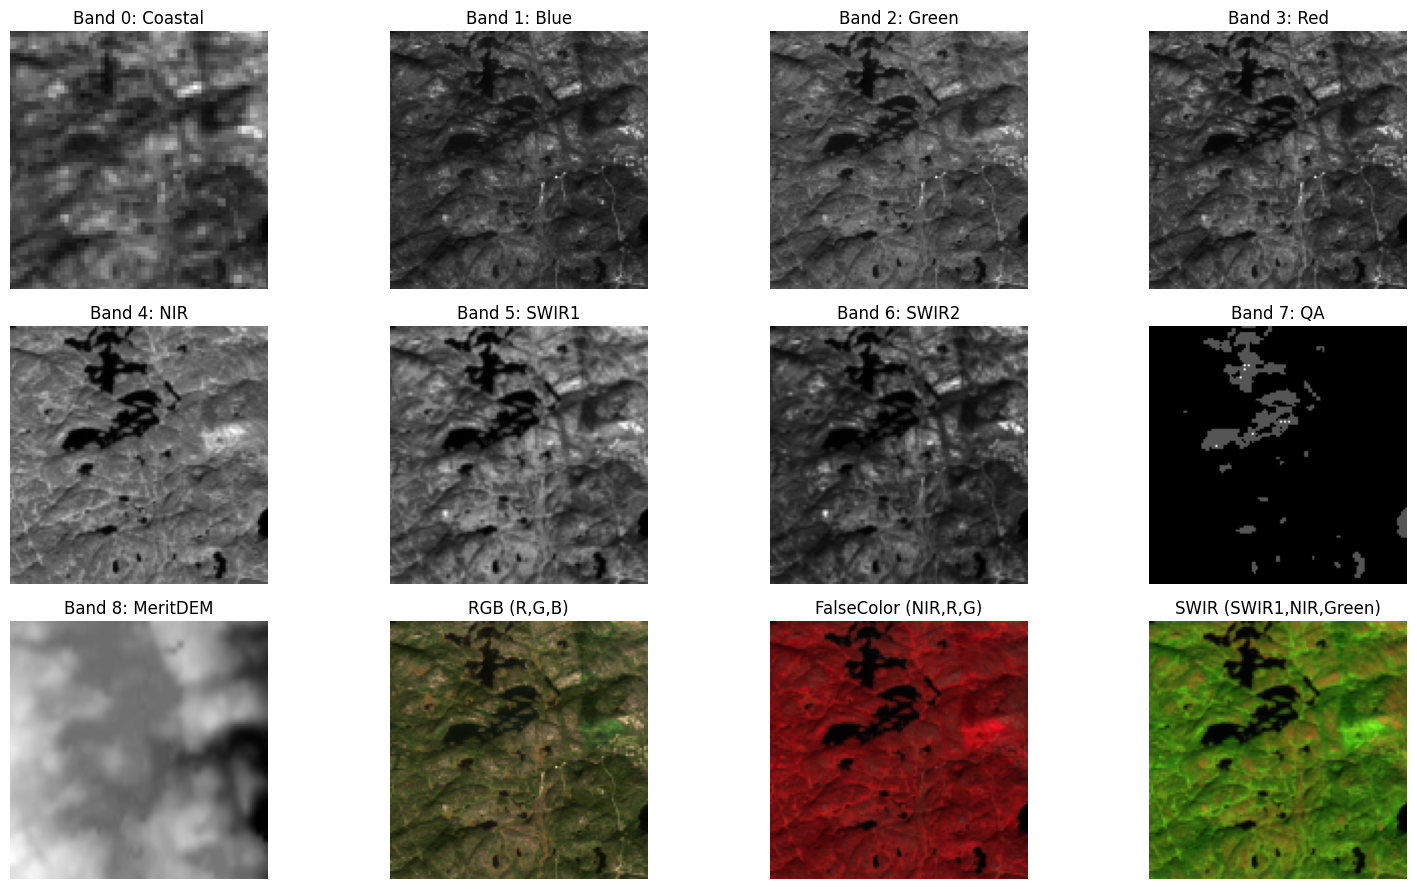

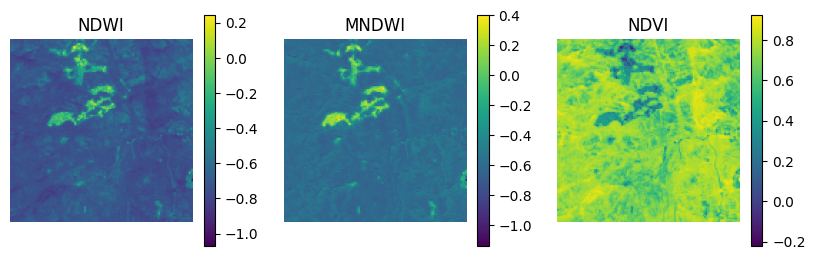

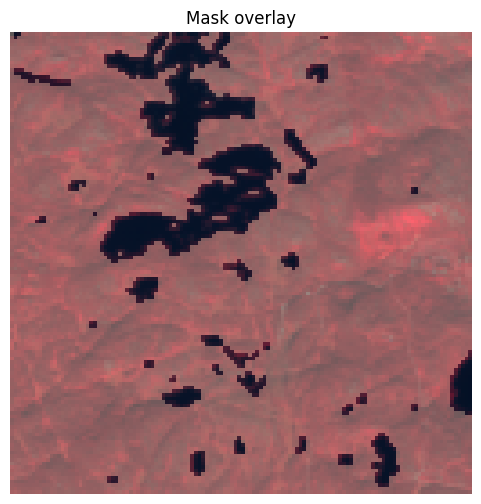

Image: 1.tif  Bands: 12  Shape: 128x128


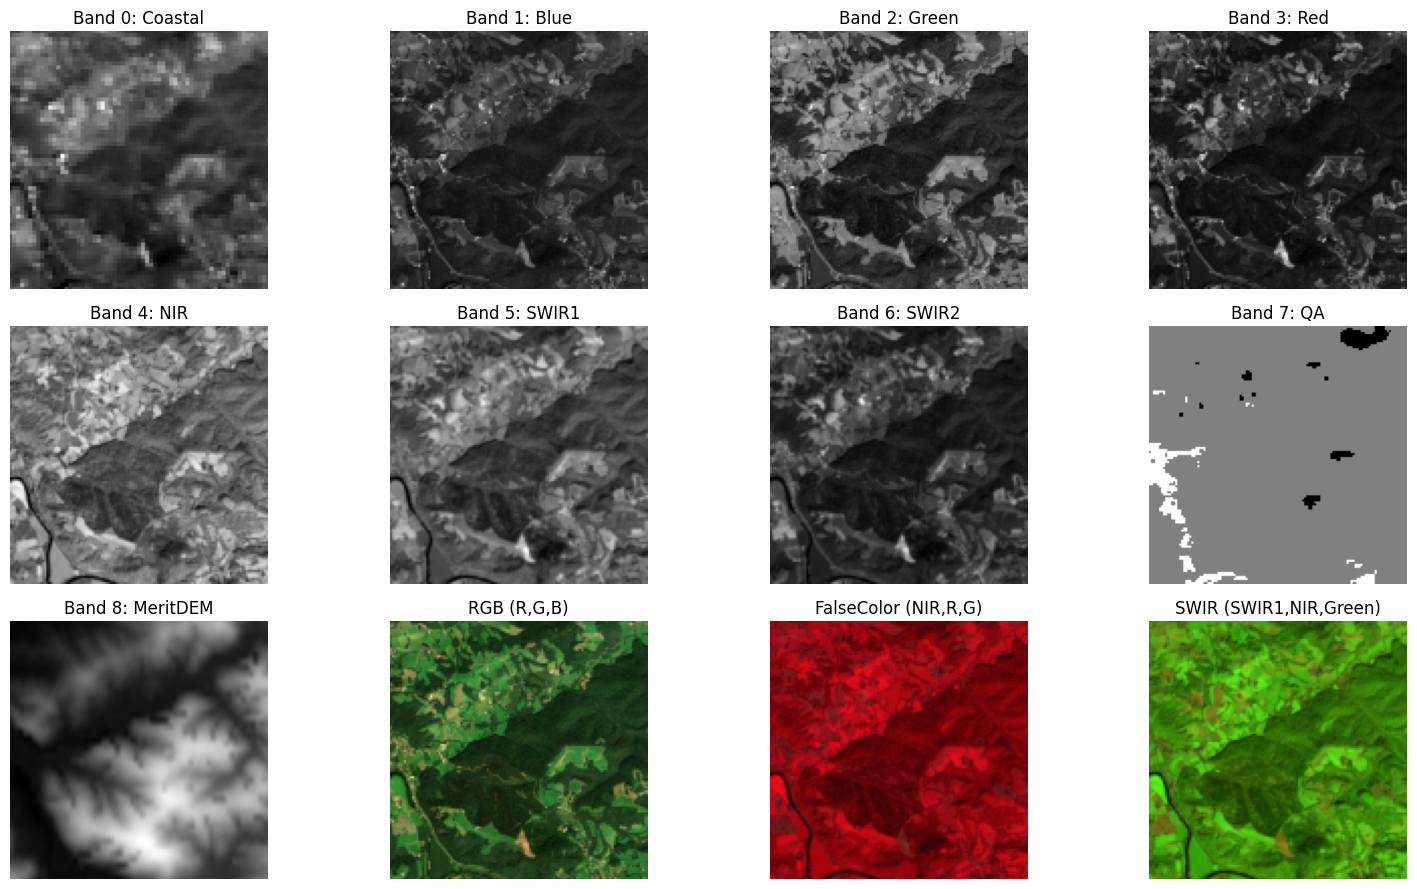

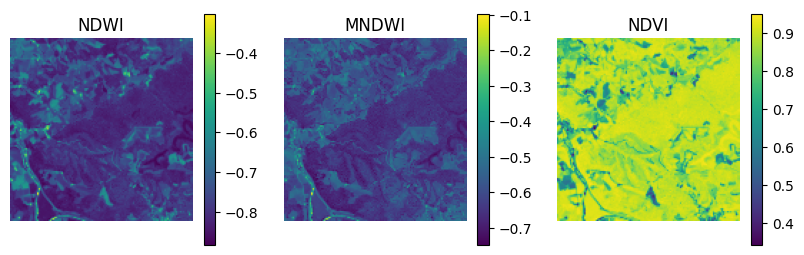

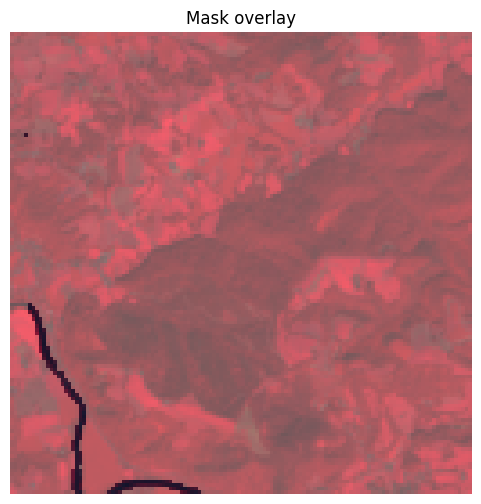

Image: 10.tif  Bands: 12  Shape: 128x128


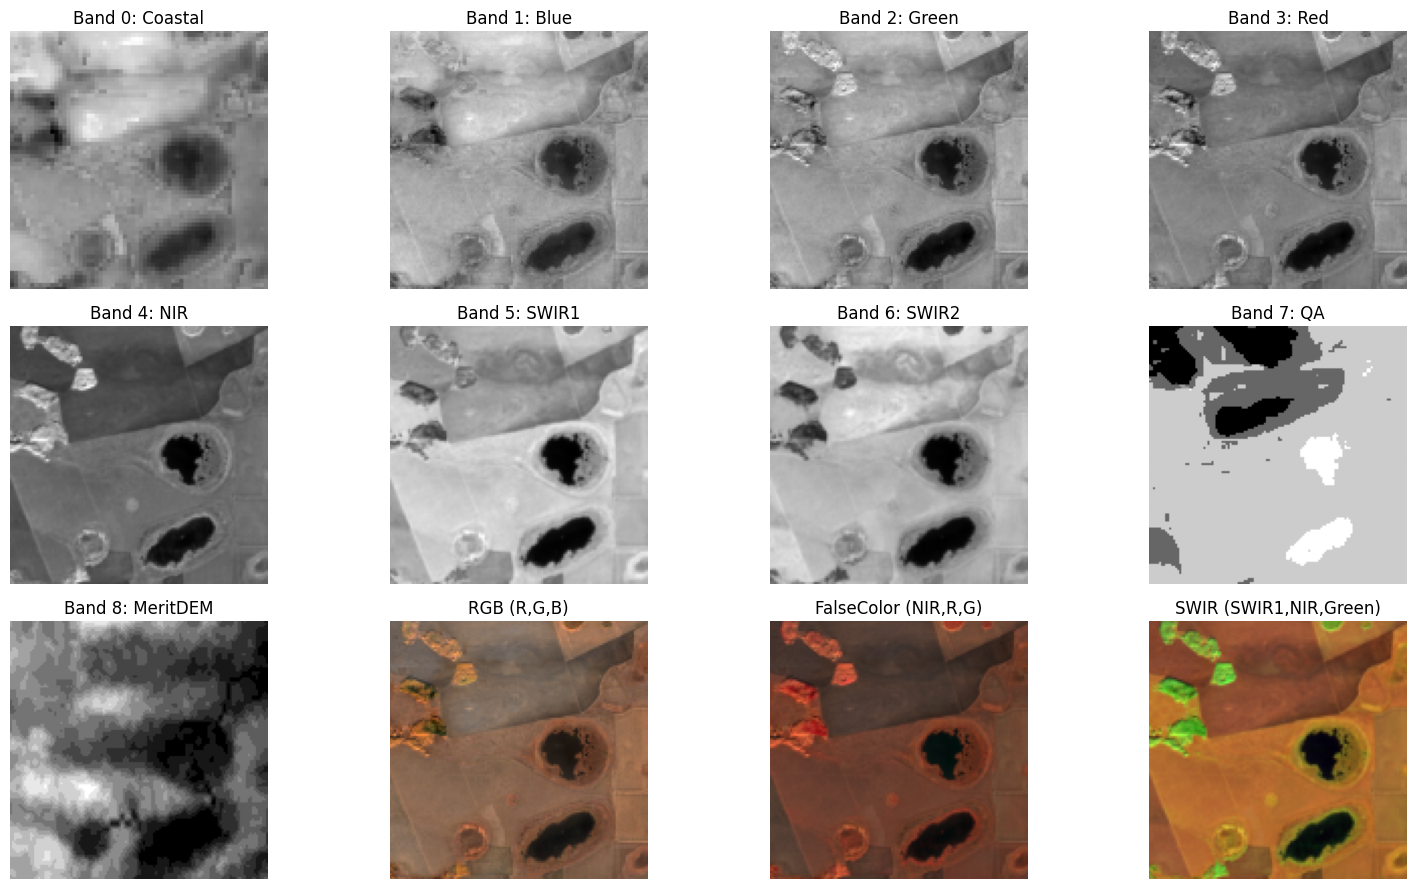

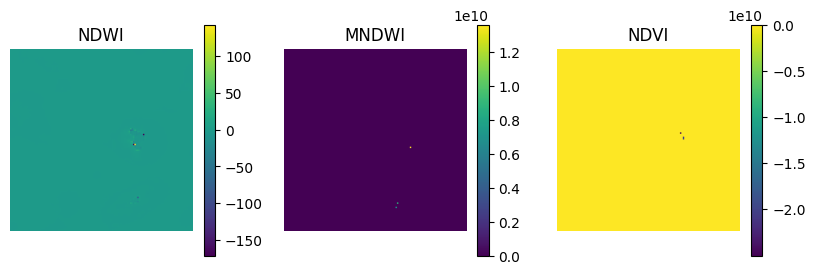

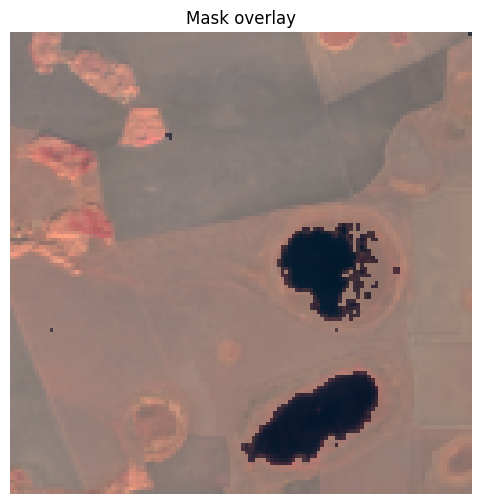

In [61]:
def show_sample_visuals(img_path, lab_path, normalizer=None, channels_to_show=None):
    arr = read_raster(img_path)  # (C,H,W)
    lab = read_raster(lab_path)[0]
    C,H,W = arr.shape
    print(f'Image: {Path(img_path).name}  Bands: {C}  Shape: {H}x{W}')
    if channels_to_show is None:
        channels_to_show = list(range(min(9,C)))
    n = len(channels_to_show)
    cols = 4
    rows = math.ceil((n+3)/cols)
    plt.figure(figsize=(4*cols, 3*rows))
    for i,ci in enumerate(channels_to_show):
        plt.subplot(rows, cols, i+1)
        b = arr[ci]
        if normalizer is not None and normalizer.means is not None and ci < len(normalizer.means):
            b_disp = normalizer.transform(arr)[ci]
        else:
            b_disp = b
        plt.imshow(b_disp, cmap='gray'); plt.title(f'Band {ci}: {CHANNEL_NAMES[ci]}'); plt.axis('off')
    def mk_comp(a,b,c):
        comp = np.stack([arr[a], arr[b], arr[c]], axis=-1)
        comp = (comp - comp.min())/(comp.max()-comp.min()+1e-8)
        return comp
    comps = [('RGB (R,G,B)', mk_comp(B_RED,B_GREEN,B_BLUE)),
             ('FalseColor (NIR,R,G)', mk_comp(B_NIR,B_RED,B_GREEN)),
             ('SWIR (SWIR1,NIR,Green)', mk_comp(B_SWIR1,B_NIR,B_GREEN))]
    for j,(name,comp) in enumerate(comps):
        plt.subplot(rows, cols, n+1+j); plt.imshow(comp); plt.title(name); plt.axis('off')
    plt.tight_layout(); plt.show()
    inds = compute_indices(arr)
    plt.figure(figsize=(10,3))
    plt.subplot(1,3,1); plt.imshow(inds['NDWI']); plt.title('NDWI'); plt.colorbar(); plt.axis('off')
    plt.subplot(1,3,2); plt.imshow(inds['MNDWI']); plt.title('MNDWI'); plt.colorbar(); plt.axis('off')
    plt.subplot(1,3,3); plt.imshow(inds['NDVI']); plt.title('NDVI'); plt.colorbar(); plt.axis('off')
    plt.show()
    fc = mk_comp(B_NIR,B_RED,B_GREEN)
    plt.figure(figsize=(6,6)); plt.imshow(fc); plt.imshow(lab, alpha=0.35, cmap='Blues'); plt.title('Mask overlay'); plt.axis('off'); plt.show()

# show first 3 examples
for img_p, lab_p in list(matches.items())[:3]:
    show_sample_visuals(img_p, lab_p)

## 6) Channel selection & Normalization
We'll append NDWI & MNDWI if enabled.

Base channels: [0, 1, 2, 3, 4, 5, 6, 8, 11] ['Coastal', 'Blue', 'Green', 'Red', 'NIR', 'SWIR1', 'SWIR2', 'MeritDEM', 'WaterProb']


C:\Users\Eng.Razan\AppData\Local\Temp\ipykernel_22120\2390135754.py:13: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([means[:,i] for i in range(means.shape[1])], labels=CHANNEL_NAMES, showfliers=False)
C:\Users\Eng.Razan\AppData\Local\Temp\ipykernel_22120\2390135754.py:16: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([stds[:,i] for i in range(stds.shape[1])], labels=CHANNEL_NAMES, showfliers=False)


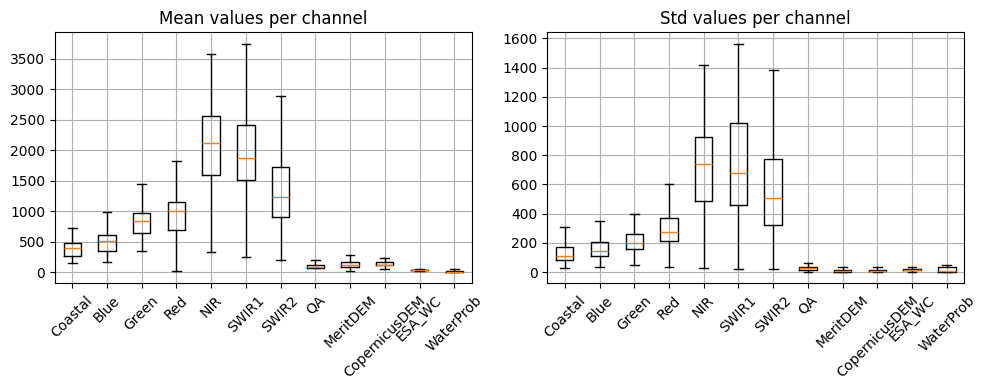

Normalizers computed: clip01
Saved normalizer stats to C:\Users\Eng.Razan\Documents\Cellula Projects\Cellula-intern\experiments_enhanced\normalizer_stats.npz


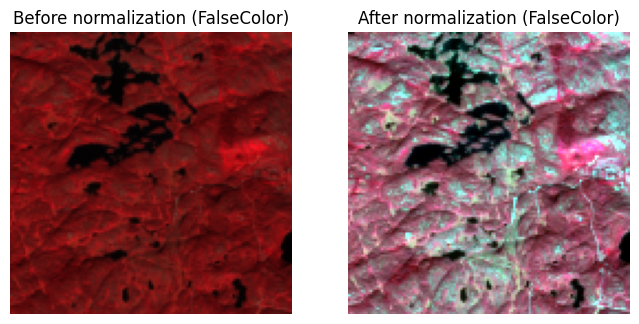

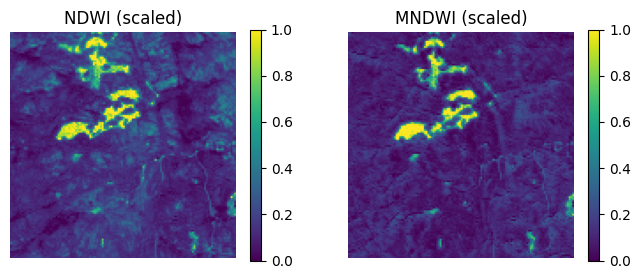

In [ ]:
base_channels = [0,1,2,3,4,5,6,8,11]
print('Base channels:', base_channels, [CHANNEL_NAMES[c] for c in base_channels])

# means = []; stds = []
# for p in picks:
#     arr = read_raster(p)
#     means.append(arr.reshape(arr.shape[0], -1).mean(axis=1))
#     stds.append(arr.reshape(arr.shape[0], -1).std(axis=1))
# means = np.array(means); stds = np.array(stds)

# plt.figure(figsize=(10,4))
# plt.subplot(1,2,1)
# plt.boxplot([means[:,i] for i in range(means.shape[1])], labels=CHANNEL_NAMES, showfliers=False)
# plt.xticks(rotation=45); plt.title('Mean values per channel'); plt.grid(True)
# plt.subplot(1,2,2)
# plt.boxplot([stds[:,i] for i in range(stds.shape[1])], labels=CHANNEL_NAMES, showfliers=False)
# plt.xticks(rotation=45); plt.title('Std values per channel'); plt.grid(True)
# plt.tight_layout(); plt.show()


train_files = [str(Path(p)) for p in img_files]
normalizer = BandNormalizers(mode='clip01')
normalizer.fit(train_files, sample_n=200)
np.savez(Path(CONFIG['save_dir'])/'normalizer_stats.npz', means=normalizer.means, stds=normalizer.stds, mins=normalizer.mins, maxs=normalizer.maxs)
print('Saved normalizer stats to', Path(CONFIG['save_dir'])/'normalizer_stats.npz')


# img_p, lab_p = list(matches.items())[0]
# arr = read_raster(img_p)
# def comp_rgb(a,b,c,arr):
#     comp = np.stack([arr[a], arr[b], arr[c]], axis=-1)
#     comp = (comp - comp.min())/(comp.max()-comp.min()+1e-8)
#     return comp
# plt.figure(figsize=(8,4))
# plt.subplot(1,2,1); plt.imshow(comp_rgb(B_NIR,B_RED,B_GREEN,arr)); plt.title('Before normalization (FalseColor)'); plt.axis('off')
# arr_norm = normalizer.transform(arr)
# plt.subplot(1,2,2); plt.imshow(comp_rgb(B_NIR,B_RED,B_GREEN,arr_norm)); plt.title('After normalization (FalseColor)'); plt.axis('off')
# plt.show()

# inds_before = compute_indices(arr)
# def scale_idx(x):
#     p1 = np.percentile(x,1); p99=np.percentile(x,99); x = np.clip(x,p1,p99); return (x-p1)/(p99-p1+1e-8)
# plt.figure(figsize=(8,3))
# plt.subplot(1,2,1); plt.imshow(scale_idx(inds_before['NDWI'])); plt.title('NDWI (scaled)'); plt.colorbar(); plt.axis('off')
# plt.subplot(1,2,2); plt.imshow(scale_idx(inds_before['MNDWI'])); plt.title('MNDWI (scaled)'); plt.colorbar(); plt.axis('off')
# plt.show()

## 7) Final train/val/test split

In [72]:
# ---- Stratified split (keeps same proportion of zero-water images) ----
all_items = list(matches.items())
has_water = []
for img_p, lab_p in all_items:
    lab = read_raster(lab_p)[0]
    has_water.append(int((lab > 0).mean() > 0))

# Convert to indices and stratify using simple split by class
idx_pos = [i for i,v in enumerate(has_water) if v==1]
idx_neg = [i for i,v in enumerate(has_water) if v==0]

random.shuffle(idx_pos); random.shuffle(idx_neg)

# desired fractions
n = len(all_items)
n_train = int(0.7*n); n_val = int(0.15*n); n_test = n - n_train - n_val

# allocate by proportion of pos/neg
def split_indices(indices, n_target):
    return indices[:n_target], indices[n_target:]

# compute how many pos/neg for each split roughly
pos_frac = sum(has_water)/len(has_water)
n_train_pos = int(n_train * pos_frac); n_val_pos = int(n_val * pos_frac)
n_test_pos = int(n_test * pos_frac)

# pick indices
train_idx = idx_pos[:n_train_pos] + idx_neg[:(n_train - n_train_pos)]
val_idx = idx_pos[n_train_pos:n_train_pos+n_val_pos] + idx_neg[(n_train - n_train_pos):(n_train - n_train_pos + (n_val - n_val_pos))]
test_idx = list(set(range(n)) - set(train_idx) - set(val_idx))

# Build splits (shuffle inside each)
random.shuffle(train_idx); random.shuffle(val_idx); random.shuffle(test_idx)

train_matches = dict([all_items[i] for i in train_idx])
val_matches   = dict([all_items[i] for i in val_idx])
test_matches  = dict([all_items[i] for i in test_idx])

print('Stratified Splits -> Train:',len(train_matches),'Val:',len(val_matches),'Test:',len(test_matches))


Stratified Splits -> Train: 214 Val: 45 Test: 47


## 8) Dataset & Dataloaders (compute indices on the fly)

In [73]:
class WaterDataset(Dataset):
    def __init__(self, matches, base_channels, normalizer, transform=None, use_indices=True):
        self.items = list(matches.items())
        self.base_channels = base_channels
        self.normalizer = normalizer
        self.transform = transform
        self.use_indices = use_indices
    def __len__(self): return len(self.items)
    def __getitem__(self, idx):
        img_path, lab_path = self.items[idx]
        arr = read_raster(img_path)
        sel = arr[self.base_channels]
        if self.use_indices:
            inds = compute_indices(arr)
            ndwi = inds['NDWI'][None,...]; mndwi = inds['MNDWI'][None,...]
            sel = np.concatenate([sel, ndwi, mndwi], axis=0)
        # normalize selected channels (original bands via normalizer, indices via percentile clip)
        k = min(sel.shape[0], len(self.normalizer.means))
        sel_norm = self.normalizer.transform(sel[:k])
        if sel.shape[0] > k:
            def scale_idx(x):
                p1 = np.percentile(x,1); p99 = np.percentile(x,99)
                x = np.clip(x, p1, p99)
                return (x - p1) / (p99 - p1 + 1e-8)
            extra = np.stack([scale_idx(sel[-2]), scale_idx(sel[-1])], axis=0)
            sel_norm = np.concatenate([sel_norm, extra], axis=0)
        lab = read_raster(lab_path)[0]
        lab = (lab > 0).astype(np.float32)
        img_hwc = np.transpose(sel_norm, (1,2,0)).astype(np.float32)
        lab_hwc = lab[..., None].astype(np.float32)
        if self.transform:
            aug = self.transform(image=img_hwc, mask=lab_hwc)
            img_hwc = aug['image']; lab_hwc = aug['mask']
        if isinstance(img_hwc, np.ndarray):
            img_tensor = torch.from_numpy(np.transpose(img_hwc, (2,0,1))).float()
        else:
            img_tensor = img_hwc.float()
        if isinstance(lab_hwc, np.ndarray):
            mask_tensor = torch.from_numpy(np.transpose(lab_hwc, (2,0,1))).float()
        else:
            if lab_hwc.dim() == 3 and lab_hwc.shape[2] == 1:
                mask_tensor = lab_hwc.permute(2,0,1).float()
            elif lab_hwc.dim() == 2:
                mask_tensor = lab_hwc.unsqueeze(0).float()
            else:
                mask_tensor = lab_hwc.float()
        return img_tensor, mask_tensor

# stronger augmentations
train_tf = A.Compose([
    A.RandomCrop(CONFIG['height'], CONFIG['width']),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.RandomBrightnessContrast(p=0.5, brightness_limit=0.2, contrast_limit=0.2),
    A.RandomGamma(p=0.3),
    A.GaussNoise(p=0.2),
    A.CoarseDropout(max_holes=8, max_height=8, max_width=8, p=0.2),
    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.15, rotate_limit=15, p=0.5, border_mode=0),
    A.Normalize(),
    ToTensorV2()
])
val_tf = A.Compose([A.CenterCrop(CONFIG['height'], CONFIG['width']), A.Normalize(), ToTensorV2()])

train_ds = WaterDataset(train_matches, base_channels, normalizer, transform=train_tf, use_indices=CONFIG['use_indices'])
val_ds   = WaterDataset(val_matches, base_channels, normalizer, transform=val_tf, use_indices=CONFIG['use_indices'])
test_ds  = WaterDataset(test_matches, base_channels, normalizer, transform=val_tf, use_indices=CONFIG['use_indices'])

train_dl = DataLoader(train_ds, batch_size=CONFIG['batch_size'], shuffle=True, num_workers=CONFIG['num_workers'], pin_memory=True)
val_dl   = DataLoader(val_ds, batch_size=CONFIG['batch_size'], shuffle=False, num_workers=CONFIG['num_workers'], pin_memory=True)
test_dl  = DataLoader(test_ds, batch_size=CONFIG['batch_size'], shuffle=False, num_workers=CONFIG['num_workers'], pin_memory=True)

print('Dataloaders ready. Sample batch shapes:')
bimgs, bmasks = next(iter(train_dl)); print('imgs', bimgs.shape, 'masks', bmasks.shape)

C:\Users\Eng.Razan\AppData\Local\Temp\ipykernel_22120\2329517644.py:58: UserWarning: Argument(s) 'max_holes, max_height, max_width' are not valid for transform CoarseDropout
  A.CoarseDropout(max_holes=8, max_height=8, max_width=8, p=0.2),


Dataloaders ready. Sample batch shapes:
imgs torch.Size([16, 11, 128, 128]) masks torch.Size([16, 1, 128, 128])


In [74]:
# ---- Oversampling train images that contain water ----
from torch.utils.data import WeightedRandomSampler

# Build weight per train sample: boost images that *contain* water
train_items = train_ds.items  # list of (img_path, lab_path) in the same order used by train_ds
sample_weights = []
for img_path, lab_path in train_items:
    lab = read_raster(lab_path)[0]
    frac = (lab > 0).mean()
    # if frac==0 => reduce weight; if has water => increase weight
    # You can tweak these numbers: e.g. water images weight 1.0, zero-water weight 0.2
    w = 1.0 if frac > 0 else 0.2
    sample_weights.append(w)

sample_weights = np.array(sample_weights, dtype=np.float32)
# normalize (optional)
sample_weights = sample_weights / sample_weights.sum()

# Weighted sampler (replacement=True allows oversampling of minority)
sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)

# Recreate train DataLoader to use sampler (note: shuffle should be False when using sampler)
train_dl = DataLoader(train_ds, batch_size=CONFIG['batch_size'], sampler=sampler,
                      num_workers=CONFIG['num_workers'], pin_memory=True)
print("Created oversampled train_dl. Example batch shapes:", next(iter(train_dl))[0].shape, next(iter(train_dl))[1].shape)


Created oversampled train_dl. Example batch shapes: torch.Size([16, 11, 128, 128]) torch.Size([16, 1, 128, 128])


## 9) Model (UNet from-scratch)

In [75]:
class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
        )
    def forward(self, x): return self.net(x)

class UNetSmall(nn.Module):
    def __init__(self, in_channels=9, out_channels=1, filters=[32,64,128,256]):
        super().__init__()
        self.enc1 = DoubleConv(in_channels, filters[0])
        self.pool = nn.MaxPool2d(2)
        self.enc2 = DoubleConv(filters[0], filters[1])
        self.enc3 = DoubleConv(filters[1], filters[2])
        self.enc4 = DoubleConv(filters[2], filters[3])

        self.up3 = nn.ConvTranspose2d(filters[3], filters[2], kernel_size=2, stride=2)
        self.dec3 = DoubleConv(filters[3], filters[2])
        self.up2 = nn.ConvTranspose2d(filters[2], filters[1], kernel_size=2, stride=2)
        self.dec2 = DoubleConv(filters[2], filters[1])
        self.up1 = nn.ConvTranspose2d(filters[1], filters[0], kernel_size=2, stride=2)
        self.dec1 = DoubleConv(filters[1], filters[0])

        self.out_conv = nn.Conv2d(filters[0], out_channels, kernel_size=1)

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool(e1))
        e3 = self.enc3(self.pool(e2))
        e4 = self.enc4(self.pool(e3))
        d3 = self.up3(e4); d3 = torch.cat([d3, e3], dim=1); d3 = self.dec3(d3)
        d2 = self.up2(d3); d2 = torch.cat([d2, e2], dim=1); d2 = self.dec2(d2)
        d1 = self.up1(d2); d1 = torch.cat([d1, e1], dim=1); d1 = self.dec1(d1)
        return self.out_conv(d1)

in_ch = (len(base_channels) + (2 if CONFIG['use_indices'] else 0))
model = UNetSmall(in_channels=in_ch, out_channels=1).to(CONFIG['device'])
print('UNetSmall ready with', in_ch, 'input channels')

UNetSmall ready with 11 input channels


## 10) Loss functions: Dice + (BCE | weighted BCE | Focal)

In [76]:
class DiceLoss(nn.Module):
    def __init__(self, eps=1e-6):
        super().__init__(); self.eps=eps
    def forward(self, logits, targets):
        probs = torch.sigmoid(logits)
        num = 2*(probs*targets).sum(dim=(2,3)) + self.eps
        den = probs.sum(dim=(2,3)) + targets.sum(dim=(2,3)) + self.eps
        return 1 - (num/den).mean()

def dice_score_torch(outputs, targets, threshold=0.5):
    outputs = torch.sigmoid(outputs)
    outputs = (outputs > threshold).float()
    inter = (outputs * targets).sum(dim=(1,2,3))
    union = outputs.sum(dim=(1,2,3)) + targets.sum(dim=(1,2,3))
    dice = (2*inter + 1e-6)/(union + 1e-6)
    return dice.mean().item()

class FocalLoss(nn.Module):
    def __init__(self, gamma=2.0, reduction='mean'):
        super().__init__(); self.gamma=gamma; self.reduction=reduction
    def forward(self, logits, targets):
        prob = torch.sigmoid(logits)
        ce = nn.functional.binary_cross_entropy_with_logits(logits, targets, reduction='none')
        p_t = prob*targets + (1-prob)*(1-targets)
        loss = ce * ((1 - p_t) ** self.gamma)
        return loss.mean() if self.reduction=='mean' else loss.sum()

def make_loss_function(train_matches):
    pos_counts = 0; total = 0
    for p,_ in train_matches.items():
        lab = read_raster(_)[0]; m = (lab > 0).astype(np.uint8)
        pos_counts += m.sum(); total += m.size
    pos_frac = pos_counts / (total + 1e-8); neg_frac = 1 - pos_frac
    print('Train positive pixel fraction:', pos_frac)
    pos_weight = torch.tensor([neg_frac / (pos_frac + 1e-8)], dtype=torch.float32).to(CONFIG['device'])
    print('Suggested pos_weight for BCE:', float(pos_weight))
    dice = DiceLoss(); focal = FocalLoss(gamma=CONFIG.get('focal_gamma',2.0))
    if CONFIG['loss_type'] == 'bce_dice':
        bce = nn.BCEWithLogitsLoss()
        return lambda outputs, targets: 0.5*bce(outputs, targets) + 0.5*dice(outputs, targets)
    elif CONFIG['loss_type'] == 'weighted_bce_dice':
        bce = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
        return lambda outputs, targets: 0.5*bce(outputs, targets) + 0.5*dice(outputs, targets)
    elif CONFIG['loss_type'] == 'focal_dice':
        return lambda outputs, targets: 0.5*focal(outputs, targets) + 0.5*dice(outputs, targets)
    else:
        bce = nn.BCEWithLogitsLoss(); return lambda outputs, targets: 0.5*bce(outputs, targets) + 0.5*dice(outputs, targets)

combined_loss = make_loss_function(train_matches)
print('Combined loss ready:', CONFIG['loss_type'])

Train positive pixel fraction: 0.24360585435528553
Suggested pos_weight for BCE: 3.1049914360046387
Combined loss ready: bce_dice


## 11) Optimizer & Scheduler

In [77]:
optimizer = torch.optim.Adam(model.parameters(), lr=CONFIG['lr'], weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)
print('Optimizer ready')

Optimizer ready


## 12) Training loop

In [78]:
import json
from pathlib import Path
best_val_loss = float('inf')
history = {'train_loss':[], 'val_loss':[], 'val_iou':[], 'val_dice':[]}
EPOCHS = CONFIG['epochs']; device = CONFIG['device']

for epoch in range(EPOCHS):
    t0 = time.time()
    model.train(); running_loss=0.0; running_dice=0.0; n_batches=0
    for imgs, masks in train_dl:
        imgs = imgs.to(device); masks = masks.to(device)
        optimizer.zero_grad(); outputs = model(imgs); loss = combined_loss(outputs, masks)
        loss.backward(); optimizer.step()
        running_loss += loss.item(); running_dice += dice_score_torch(outputs, masks); n_batches += 1
    avg_train_loss = running_loss / n_batches if n_batches else 0.0

    # validation
    model.eval(); v_loss=0.0; v_iou=0.0; v_dice=0.0; vb=0
    with torch.no_grad():
        for imgs, masks in val_dl:
            imgs = imgs.to(device); masks = masks.to(device)
            outputs = model(imgs); v_loss += combined_loss(outputs, masks).item()
            preds = (torch.sigmoid(outputs)>0.5).float()
            inter = (preds * masks).sum(dim=(1,2,3)); union = (preds + masks - preds*masks).sum(dim=(1,2,3)) + 1e-8
            v_iou += (inter/union).mean().item(); v_dice += dice_score_torch(outputs, masks); vb += 1
    avg_val_loss = v_loss / vb if vb else 0.0; avg_val_iou = v_iou / vb if vb else 0.0; avg_val_dice = v_dice / vb if vb else 0.0
    scheduler.step(avg_val_loss)
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss; torch.save(model.state_dict(), Path(CONFIG['save_dir'])/'best_model.pth'); print(f'Epoch {epoch+1}: New best model saved!')
    history['train_loss'].append(avg_train_loss); history['val_loss'].append(avg_val_loss); history['val_iou'].append(avg_val_iou); history['val_dice'].append(avg_val_dice)
    print(f'Epoch {epoch+1}/{EPOCHS} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Val IoU: {avg_val_iou:.4f} | Val Dice: {avg_val_dice:.4f} | Time: {time.time()-t0:.1f}s')

with open(Path(CONFIG['save_dir'])/'history.json','w') as f: json.dump(history, f)
print('Training finished')

Epoch 1: New best model saved!
Epoch 1/60 | Train Loss: 0.5743 | Val Loss: 0.8223 | Val IoU: 0.2816 | Val Dice: 0.3736 | Time: 4.3s
Epoch 2: New best model saved!
Epoch 2/60 | Train Loss: 0.4878 | Val Loss: 0.7690 | Val IoU: 0.0000 | Val Dice: 0.1554 | Time: 3.9s
Epoch 3: New best model saved!
Epoch 3/60 | Train Loss: 0.4805 | Val Loss: 0.6830 | Val IoU: 0.0000 | Val Dice: 0.1554 | Time: 3.9s
Epoch 4/60 | Train Loss: 0.4446 | Val Loss: 0.7607 | Val IoU: 0.0000 | Val Dice: 0.1554 | Time: 3.9s
Epoch 5/60 | Train Loss: 0.4388 | Val Loss: 2.0251 | Val IoU: 0.0000 | Val Dice: 0.1554 | Time: 3.8s
Epoch 6/60 | Train Loss: 0.4112 | Val Loss: 1.1523 | Val IoU: 0.2819 | Val Dice: 0.3740 | Time: 3.7s
Epoch 7/60 | Train Loss: 0.4019 | Val Loss: 1.4636 | Val IoU: 0.0005 | Val Dice: 0.1565 | Time: 3.7s
Epoch 8/60 | Train Loss: 0.4134 | Val Loss: 1.8496 | Val IoU: 0.0000 | Val Dice: 0.1554 | Time: 3.8s
Epoch 9/60 | Train Loss: 0.4096 | Val Loss: 0.9793 | Val IoU: 0.0000 | Val Dice: 0.1554 | Time: 3.8

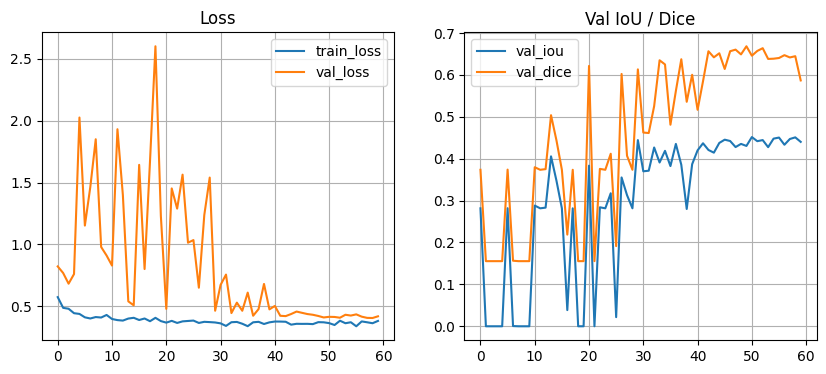

In [80]:
# ---------- Cell: Plot training curves ----------
import matplotlib.pyplot as plt
h = history
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(h['train_loss'], label='train_loss')
plt.plot(h['val_loss'], label='val_loss')
plt.legend(); plt.title('Loss'); plt.grid(True)

plt.subplot(1,2,2)
plt.plot(h['val_iou'], label='val_iou')
plt.plot(h['val_dice'], label='val_dice')
plt.legend(); plt.title('Val IoU / Dice'); plt.grid(True)
plt.show()


## 13) Test evaluation & postprocessing

In [81]:
model.load_state_dict(torch.load(Path(CONFIG['save_dir'])/'best_model.pth')) 
model.eval(); device = CONFIG['device']

test_loss=0.0; test_iou=0.0; test_dice=0.0; tb=0
with torch.no_grad():
    for imgs, masks in test_dl:
        imgs = imgs.to(device); masks = masks.to(device)
        outputs = model(imgs)
        test_loss += combined_loss(outputs, masks).item()
        preds = (torch.sigmoid(outputs)>0.5).float()
        inter = (preds * masks).sum(dim=(1,2,3)); union = (preds + masks - preds*masks).sum(dim=(1,2,3)) + 1e-8
        test_iou += (inter/union).mean().item(); test_dice += dice_score_torch(outputs, masks); tb += 1
print('Test Loss:', test_loss/tb, 'Test IoU:', test_iou/tb, 'Test Dice:', test_dice/tb)

def postprocess_mask(mask_arr, min_size=CONFIG['min_component_size']):
    mask_bool = mask_arr.astype(bool)
    cleaned = morphology.remove_small_objects(mask_bool, min_size=min_size)
    cleaned = morphology.remove_small_holes(cleaned, area_threshold=min_size)
    return cleaned.astype(np.uint8)


C:\Users\Eng.Razan\AppData\Local\Temp\ipykernel_22120\2274994335.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(Path(CONFIG['save_dir']

Test Loss: 0.34377459685007733 Test IoU: 0.5455274780591329 Test Dice: 0.6887912551561991


##  Visualization & Error Maps
Show input, GT, prediction and error map with per-sample IoU/Dice.

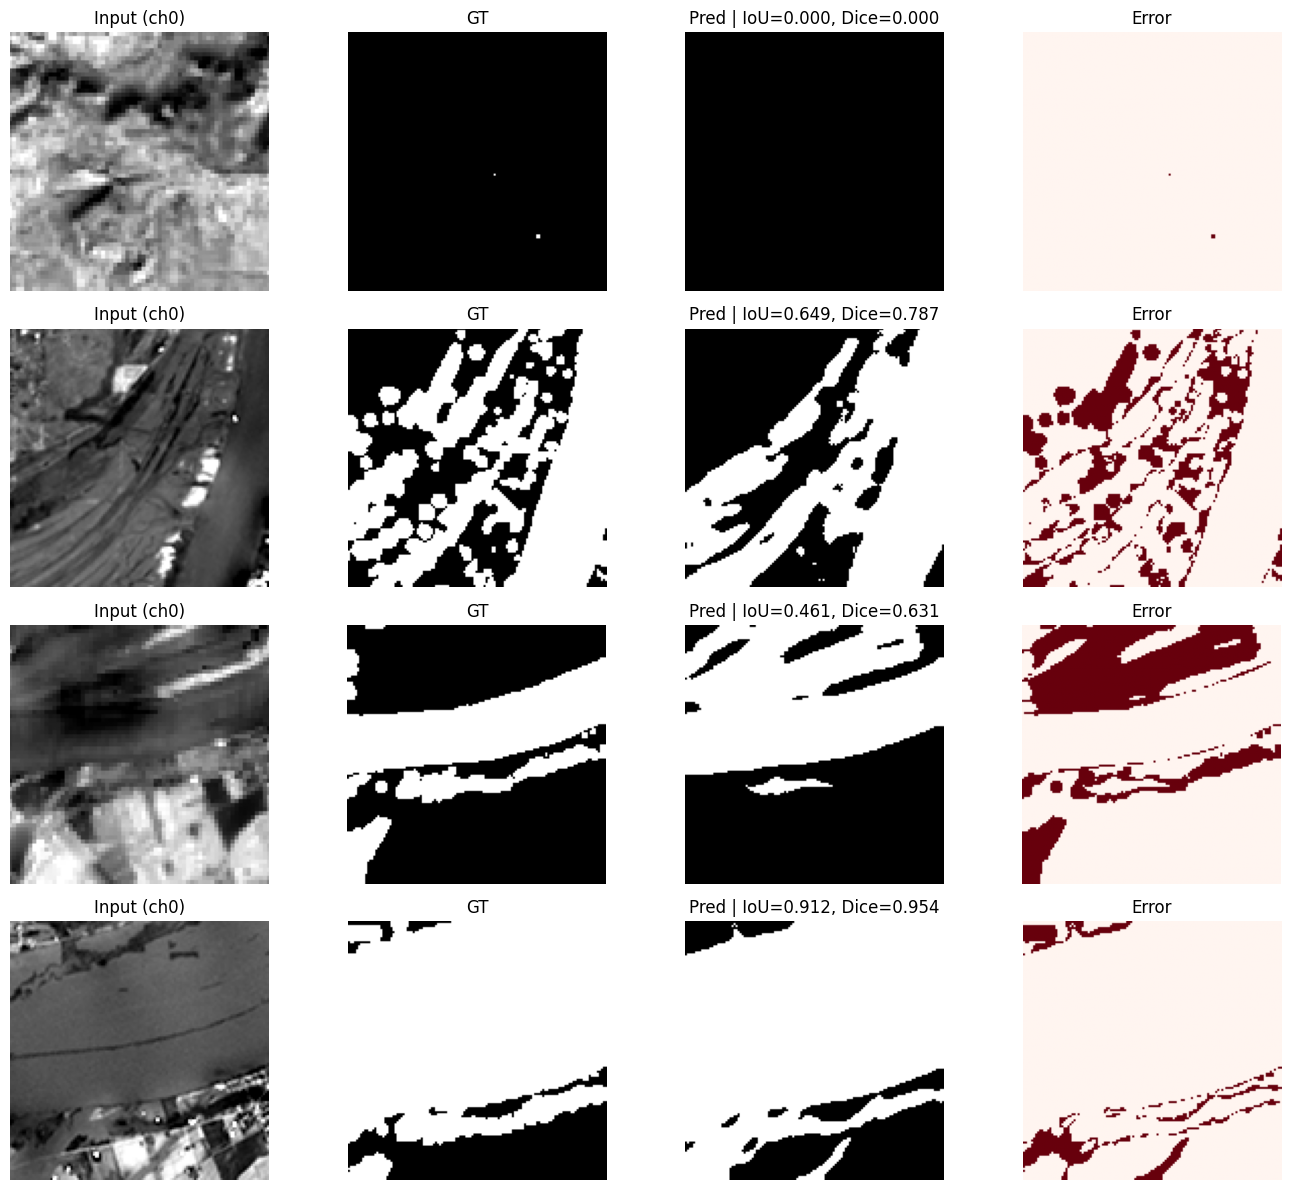

In [82]:
def visualize_with_error_maps(model, dataloader, device, num_samples=4, threshold=0.5, channel=0):
    model.eval()
    imgs, masks = next(iter(dataloader))
    imgs, masks = imgs.to(device), masks.to(device)
    with torch.no_grad():
        outputs = model(imgs)
        probs = torch.sigmoid(outputs)
        preds = (probs>threshold).float()
    n_show = min(num_samples, imgs.shape[0])
    plt.figure(figsize=(14, 3*n_show))
    for i in range(n_show):
        img = imgs[i, channel].cpu().numpy()
        gt = masks[i,0].cpu().numpy()
        pred = preds[i,0].cpu().numpy()
        inter = (gt*pred).sum(); union = ((gt+pred)>0).sum()
        iou = inter/(union+1e-8); dice = (2*inter)/(gt.sum()+pred.sum()+1e-8)
        err = (gt != pred).astype(float)
        plt.subplot(n_show,4,4*i+1); plt.imshow(img, cmap='gray'); plt.title('Input (ch{})'.format(channel)); plt.axis('off')
        plt.subplot(n_show,4,4*i+2); plt.imshow(gt, cmap='gray'); plt.title('GT'); plt.axis('off')
        plt.subplot(n_show,4,4*i+3); plt.imshow(pred, cmap='gray'); plt.title(f'Pred | IoU={iou:.3f}, Dice={dice:.3f}'); plt.axis('off')
        plt.subplot(n_show,4,4*i+4); plt.imshow(err, cmap='Reds'); plt.title('Error'); plt.axis('off')
    plt.tight_layout(); plt.show()

visualize_with_error_maps(model, test_dl, CONFIG['device'], num_samples=4, threshold=0.5)

## 14) Full evaluation & classification report

Classification report (threshold=0.5):\n
              precision    recall  f1-score   support

  Background       0.90      0.95      0.92    526539
       Water       0.87      0.78      0.83    243509

    accuracy                           0.89    770048
   macro avg       0.89      0.87      0.87    770048
weighted avg       0.89      0.89      0.89    770048



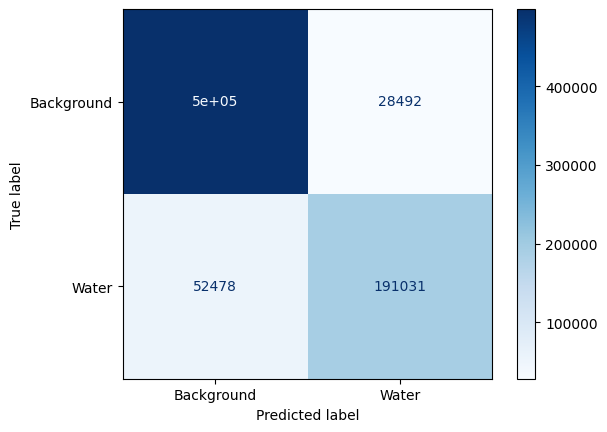

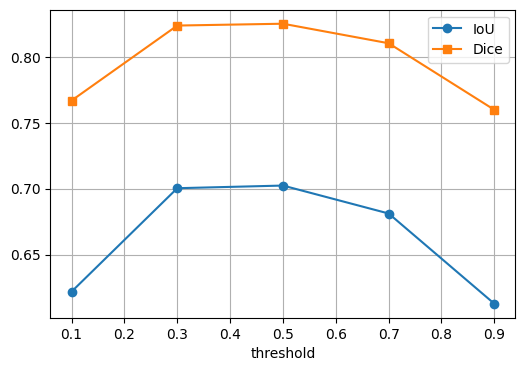

In [83]:
def full_evaluation(model, dataloader, device, thresholds=[0.1,0.3,0.5,0.7,0.9]):
    model.eval()
    y_true = []; y_probs = []
    with torch.no_grad():
        for imgs, masks in dataloader:
            imgs, masks = imgs.to(device), masks.to(device)
            outputs = model(imgs)
            probs = torch.sigmoid(outputs).cpu().numpy().ravel()
            y_probs.extend(probs); y_true.extend(masks.cpu().numpy().ravel().astype(int))
    y_true = np.array(y_true); y_probs = np.array(y_probs)
    t = 0.5
    y_pred = (y_probs > t).astype(int)
    print('Classification report (threshold=0.5):\\n'); print(classification_report(y_true, y_pred, target_names=['Background','Water']))
    cm = confusion_matrix(y_true, y_pred); disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Background','Water']); disp.plot(cmap='Blues'); plt.show()
    ious=[]; dices=[]
    for th in thresholds:
        yp = (y_probs>th).astype(int); inter = np.logical_and(y_true==1, yp==1).sum(); union = np.logical_or(y_true==1, yp==1).sum()
        iou = inter/(union+1e-8); dice = (2*inter)/(y_true.sum()+yp.sum()+1e-8); ious.append(iou); dices.append(dice)
    plt.figure(figsize=(6,4)); plt.plot(thresholds, ious, marker='o', label='IoU'); plt.plot(thresholds, dices, marker='s', label='Dice'); plt.legend(); plt.grid(True); plt.xlabel('threshold'); plt.show()

full_evaluation(model, test_dl, CONFIG['device'])

## 15) Conclusions & next steps
- This notebook adds indices, stronger augmentations and imbalance handling while keeping a from-scratch UNet.
- Try switching CONFIG['loss_type'] and compare.
- For more gains consider oversampling water-containing tiles or ensembling.
